In [184]:
# Import statements
import numpy as np

# Plottting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D

# Setting plotting configuration
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

# Solving lorenz equation
from scipy import integrate

# Torch
import torch
import torch.nn as nn
import torch.optim as optim

# Neural Network for State Prediction (Lorenz Equations)

In [190]:
# Compute data matrix from lorenz equation &
# plot Lorenz states
def compute_lorenz(config):
    # initialize X and Y matrix
    x_input = np.zeros((100*(len(config['t'])-1),3))
    y_output = np.zeros_like(x_input)
    
    # generate random initial conditions
    np.random.seed(123)
    x0 = -15 + 30 * np.random.random((100, 3))
    
    # derive Lorenz equation
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])
    
    # plot states
    fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
    for j in range(100):
        x_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
        y_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
        x, y, z = x_t[j,:,:].T
        ax.plot(x, y, z,linewidth=1)
        ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')

    ax.view_init(18, -113)
    plt.show()
    
    return x_input, y_output

In [191]:
# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(in_features=3, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=200)
        self.fc3 = nn.Linear(in_features=200, out_features=3)
        self.relu = nn.ReLU()
        self.sig = nn.LogSigmoid()
        self.gelu = nn.GELU()
        
    def radbas(self, x):
        return torch.exp(-torch.pow(x, 2))

    def forward(self, x):
        x = self.fc1(x)
        x = self.sig(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.fc3(x)
        return x

In [192]:
# Define model training
def trainer(model, x_input, y_output, lr, momentum, n_epochs):
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # Convert numpy arrays to PyTorch tensors
    nn_input = torch.from_numpy(x_input).float()
    nn_output = torch.from_numpy(y_output).float()

    # Train the model
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(nn_input)
        loss = criterion(outputs, nn_output)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, loss={loss.item():.4f}")

## Train a NN to advance the solution from t to t + ∆t for ρ = 10

In [205]:
# Lorenz equation parameters
config = {
    'dt': 0.01,                # time increment
    'T': 8,                    # total time
    't': np.arange(0,T+dt,dt), # time interval
    'beta': 8/3,
    'sigma': 10,
    'rho': 10
}

In [206]:
# Define lorenz equation
def lorenz_deriv(x_y_z, t0, sigma=config['sigma'], beta=config['beta'], rho=config['rho']):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

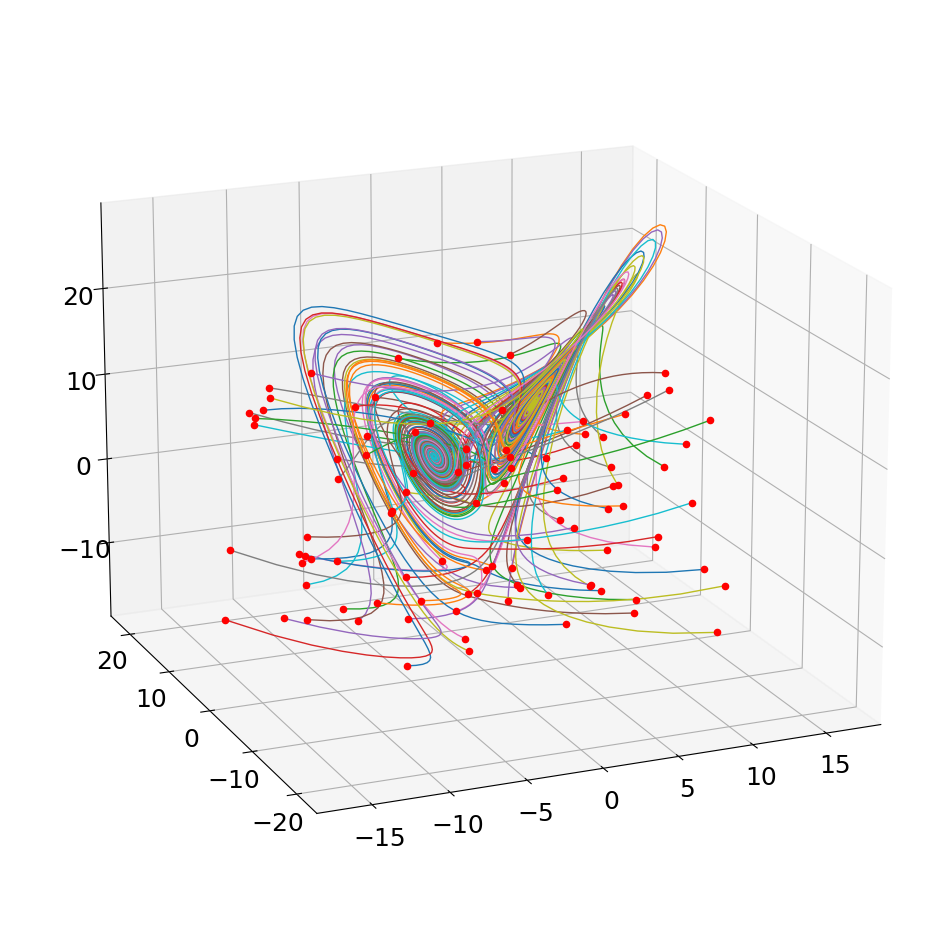

In [208]:
x10_input, y_output = compute_lorenz(config)

In [172]:
outputs.shape
nn_output.shape

torch.Size([80000, 3])

(3,)


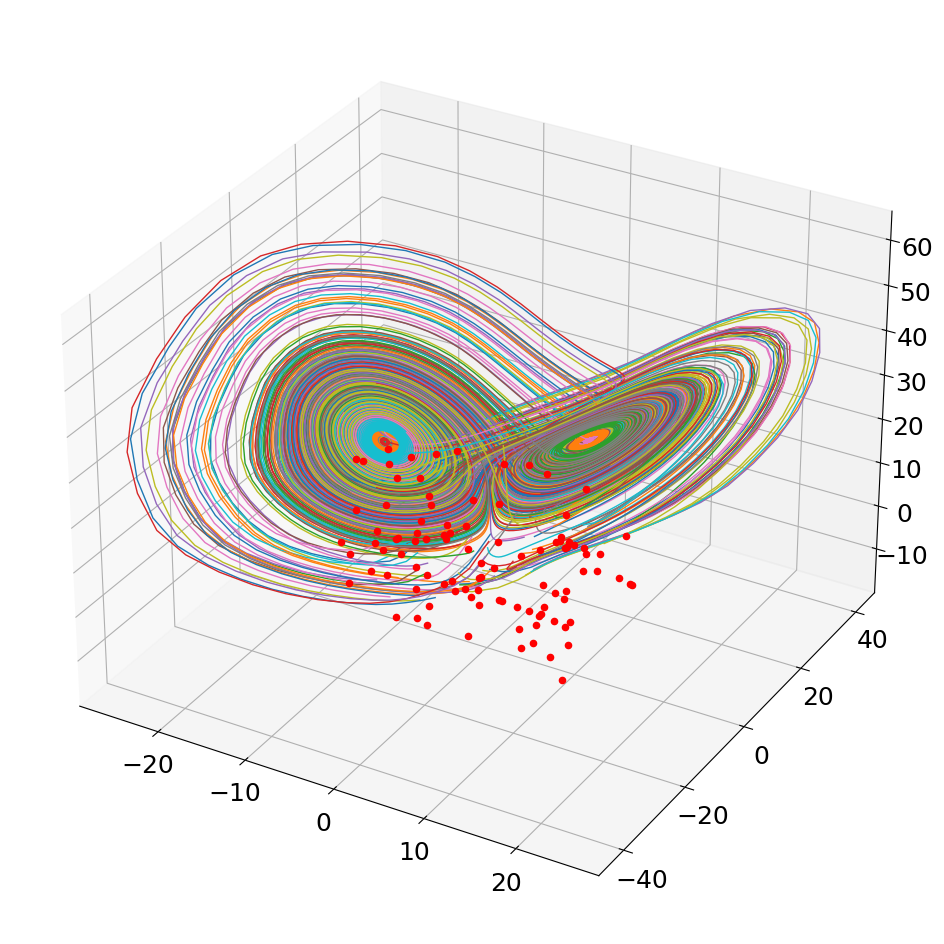

In [173]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

xyz = outputs.detach().numpy()
print(xyz[j].shape)
for j in range(100):
    ax.plot(xyz[j*800:(j+1)*800,0], xyz[j*800:(j+1)*800,1], xyz[j*800:(j+1)*800,2], linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             

plt.show()

In [166]:
print(outputs)

tensor([[-1.3592, -3.1313,  0.0795],
        [-1.4514, -1.8231, -0.6193],
        [-1.2813, -0.8759, -0.9461],
        ...,
        [-7.8378, -5.2280, 28.9851],
        [-7.6102, -5.1150, 28.6318],
        [-7.3949, -5.0332, 28.2685]], grad_fn=<AddmmBackward0>)


In [167]:
print(nn_output)

tensor([[ 4.8219, -4.4293, -8.2638],
        [ 4.0229, -2.7980, -8.2030],
        [ 3.4416, -1.4340, -8.0646],
        ...,
        [-7.6409, -5.3833, 28.8228],
        [-7.4209, -5.2815, 28.4603],
        [-7.2135, -5.2089, 28.0899]])


In [178]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(nn_output, outputs.detach().numpy()))

0.18903704
